In [1]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/01_source.wav')
(target_fs, target_data) = wavfile.read('./data/01_peak_compressor.wav')


In [2]:
import pandas as pd

In [3]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])
source_df.head()

,L,R
0,1,-1
1,-5,-6
2,-11,-12
3,-18,-17
4,-24,-24


In [4]:
target_df = pd.DataFrame(target_data, columns=['L', 'R'])
target_df.head()

,L,R
0,-1,0
1,-37,-37
2,-81,-81
3,-128,-128
4,-177,-178


In [5]:
source_df['L'].max(), target_df['L'].max()

(10790, 16537)

In [6]:
2 ** 15

32768

In [7]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [8]:
len(source_df), len(target_df)

(1302647, 1302647)

In [9]:
# END_LOC = int(len(target_df) * 0.8)
TR_END_LOC = int(len(target_df) * 0.8 / 100) * 100
TR_END_LOC

1042100

## IT'S MONO

In [10]:
X_train_raw = source_df['L'][:TR_END_LOC]
len(X_train_raw)

1042100

In [11]:
X_test_raw = source_df['L'][TR_END_LOC:]
len(X_test_raw)

260547

In [12]:
y_train_raw = target_df['L'][:TR_END_LOC]
len(y_train_raw)

1042100

In [13]:
y_test_raw = target_df['L'][TR_END_LOC:]
len(y_test_raw)

260547

In [14]:
X_test_raw.iloc[:10]

1042100    3458
1042101    3469
1042102    3479
1042103    3485
1042104    3490
1042105    3491
1042106    3489
1042107    3485
1042108    3479
1042109    3471
Name: L, dtype: int16

In [15]:
# safe-checking data

In [16]:
# y_train_raw = -y_train_raw + 4000
# y_train_raw.iloc[0]

In [17]:
# y_test_raw = -y_test_raw + 4000
# y_test_raw.iloc[0]

## Preparing data for processing

In [18]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [19]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [20]:
import numpy as np

X_tr = np.array(list(map(lambda x: np.array(x), X_train_raw)))
X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(-0.30961027863399154, 0.3292947172460097, 5.524491569495269e-06)

In [21]:
X_te = np.array(list(map(lambda x: np.array(x), X_test_raw)))
X_te_n= normalize(X_te, forced_abs=MAX_VALUE, mean=0.0)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038026062807, 0.2346873378704184, 1.2222185906085745e-05)

In [22]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train_raw)))
y_tr_n = normalize(y_tr, forced_abs=MAX_VALUE, mean=0.0)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.3057954649494919, 0.5046845912045655, -0.0002333393516189353)

In [23]:
y_te = np.array(list(map(lambda x: np.array(x), y_test_raw)))
y_te_n = normalize(y_te, forced_abs=MAX_VALUE, mean=0.0)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.2708517715994751, 0.43766594439527573, -2.5239466909497803e-05)

In [24]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

In [25]:
pd.Series(X_tr_n[:800]).plot.line(figsize=(16, 8))

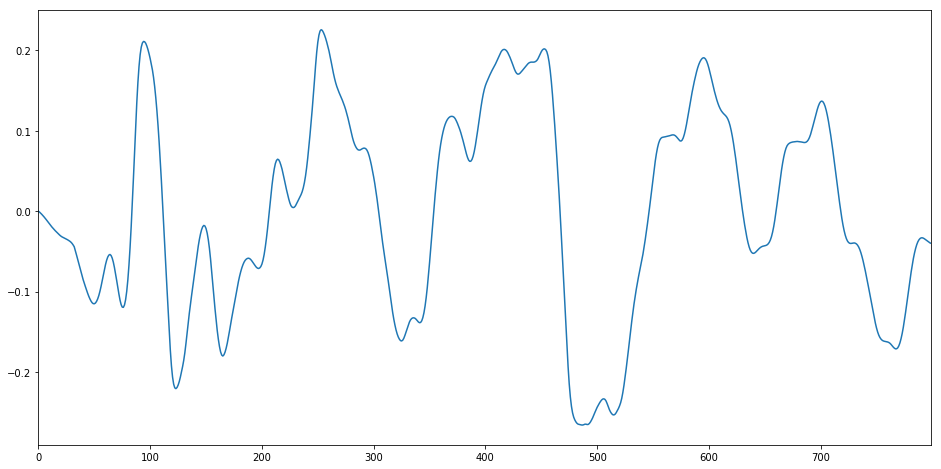

In [26]:
pd.Series(y_tr_n[:800]).plot.line(figsize=(16, 8))

In [27]:

X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038, 0.23468734, 1.2222178e-05)

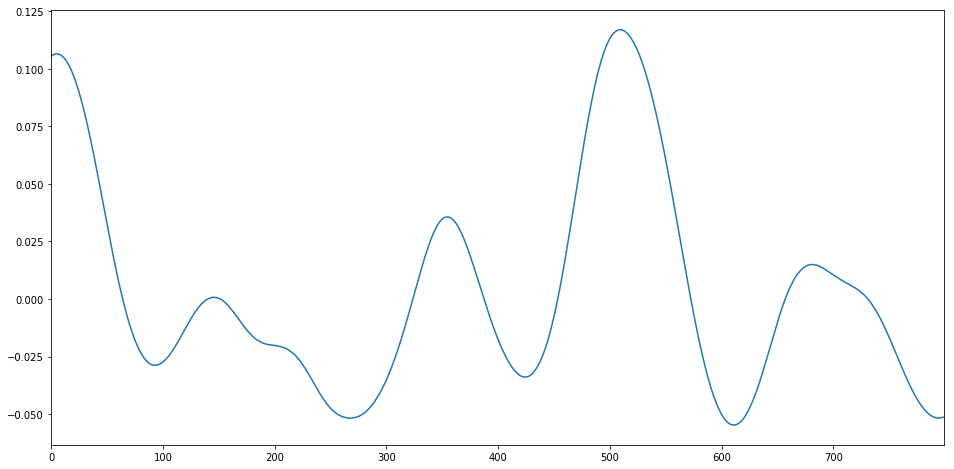

In [28]:
pd.Series(X_te_n[:800]).plot.line(figsize=(16, 8))

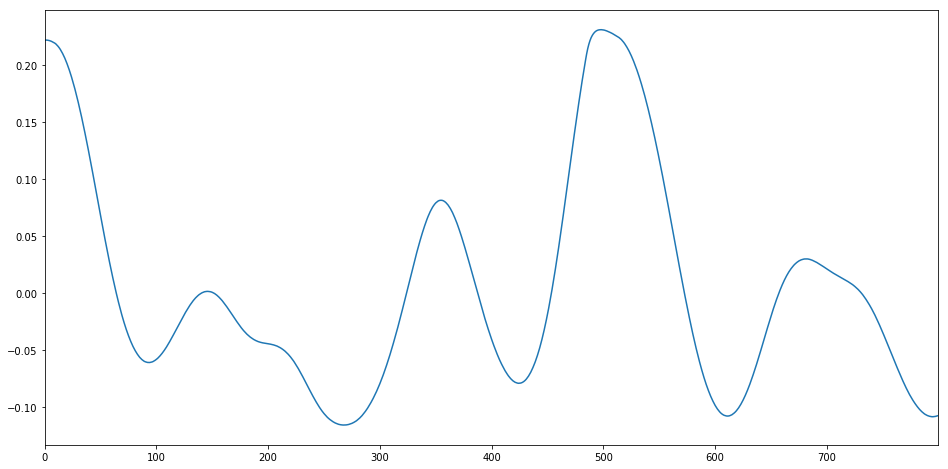

In [29]:
pd.Series(y_te_n[:800]).plot.line(figsize=(16, 8))

In [30]:
# appending stats of the whole sample, fading from silence

In [31]:
# train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_n)))
# test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_n)))

# X_tr_f = X_tr_n[train_shuffle_index][0]
# y_tr_f = y_tr_n[train_shuffle_index][0]

# X_te_f = X_te_n[test_shuffle_index][0]
# y_te_f = y_te_n[test_shuffle_index][0]

## Making windows

In [187]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 64
N_WINDOW_POINTS

64

In [444]:
N_SAMPLES = 8000
N_SAMPLES

8000

In [445]:
def make_windows(X, y, n_window_points):
    X_index = X.index
    index = 0
    
    res_X = []
    res_y = []

    for index in range(0, len(X) - n_window_points - 1):
        res_X.append(X.iloc[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y.iloc[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [446]:
%%time
(X_tr_f, y_tr_f) = make_windows(
    pd.Series(X_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    pd.Series(y_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    N_WINDOW_POINTS)
print((len(X_tr_f), X_tr_f[0], y_tr_f[0]))

(8000, array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
       -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
       -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
       -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
       -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
       -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
       -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
       -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
       -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
       -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
       -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
       -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
       -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
       -1.55949583

In [447]:
X_tr_f[1], y_tr_f[1]

(array([-0.00015259, -0.0003357 , -0.00054933, -0.00073244, -0.00091556,
        -0.00112918, -0.00140385, -0.00161748, -0.00186163, -0.00210578,
        -0.00238044, -0.00259407, -0.0028077 , -0.00302133, -0.00323496,
        -0.00338755, -0.00354015, -0.00375378, -0.00393689, -0.00408948,
        -0.00421155, -0.00430311, -0.00439467, -0.0044557 , -0.00457778,
        -0.00469985, -0.00479141, -0.004944  , -0.00506607, -0.00531022,
        -0.00552385, -0.00585955, -0.00650044, -0.00714133, -0.00787378,
        -0.00854518, -0.00927763, -0.00994903, -0.01068148, -0.01129185,
        -0.0118717 , -0.01248207, -0.01306192, -0.01367229, -0.01422163,
        -0.01474044, -0.01519822, -0.01559496, -0.01583911, -0.01593066,
        -0.01583911, -0.01559496, -0.01519822, -0.01461837, -0.01388592,
        -0.0130314 , -0.01211585, -0.01113926, -0.01019318, -0.00924711,
        -0.00851466, -0.00793481, -0.00759911, -0.00747703], dtype=float32),
 -0.053773616)

In [448]:
%%time
(X_te_f, y_te_f) = make_windows(
    pd.Series(X_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    pd.Series(y_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    N_WINDOW_POINTS
)
print((len(X_te_f), X_te_f[0], y_te_f[0]))

(8000, array([0.105533  , 0.10586871, 0.1061739 , 0.10635701, 0.1065096 ,
       0.10654011, 0.10647908, 0.10635701, 0.1061739 , 0.10592975,
       0.105533  , 0.10507523, 0.10455641, 0.10391553, 0.1032136 ,
       0.10242012, 0.10153508, 0.10058901, 0.09955138, 0.09839167,
       0.09720145, 0.09588916, 0.09454634, 0.09305093, 0.09155553,
       0.08990753, 0.08822901, 0.08648945, 0.08465835, 0.0827662 ,
       0.08084353, 0.07882931, 0.07672353, 0.07458724, 0.07238991,
       0.07016205, 0.06787317, 0.06552324, 0.0631428 , 0.06073184,
       0.05829035, 0.05578784, 0.05328532, 0.0507828 , 0.04821924,
       0.04565569, 0.04306162, 0.04049806, 0.03790399, 0.03530991,
       0.03277688, 0.03021332, 0.02764977, 0.02517777, 0.02264473,
       0.02023377, 0.01782281, 0.01544237, 0.01312296, 0.01083407,
       0.00860622, 0.00640889, 0.00424207, 0.00219733], dtype=float32), 0.0045777764)
CPU times: user 1.24 s, sys: 42.3 ms, total: 1.28 s
Wall time: 1.4 s


In [449]:
X_te_f[1], y_te_f[1]

(array([0.10586871, 0.1061739 , 0.10635701, 0.1065096 , 0.10654011,
        0.10647908, 0.10635701, 0.1061739 , 0.10592975, 0.105533  ,
        0.10507523, 0.10455641, 0.10391553, 0.1032136 , 0.10242012,
        0.10153508, 0.10058901, 0.09955138, 0.09839167, 0.09720145,
        0.09588916, 0.09454634, 0.09305093, 0.09155553, 0.08990753,
        0.08822901, 0.08648945, 0.08465835, 0.0827662 , 0.08084353,
        0.07882931, 0.07672353, 0.07458724, 0.07238991, 0.07016205,
        0.06787317, 0.06552324, 0.0631428 , 0.06073184, 0.05829035,
        0.05578784, 0.05328532, 0.0507828 , 0.04821924, 0.04565569,
        0.04306162, 0.04049806, 0.03790399, 0.03530991, 0.03277688,
        0.03021332, 0.02764977, 0.02517777, 0.02264473, 0.02023377,
        0.01782281, 0.01544237, 0.01312296, 0.01083407, 0.00860622,
        0.00640889, 0.00424207, 0.00219733, 0.00015259], dtype=float32),
 0.0003357036)

In [450]:
# import numpy as np

# train_shuffle_index = np.arange(0, len(X_tr_f))
# np.random.shuffle(train_shuffle_index)

# test_shuffle_index = np.arange(0, len(X_te_f))
# np.random.shuffle(test_shuffle_index)

# X_tr_f = np.array(X_tr_f)[train_shuffle_index]
# y_tr_f = np.array(y_tr_f)[train_shuffle_index]

# X_te_f = np.array(X_te_f)[test_shuffle_index]
# y_te_f = np.array(y_te_f)[test_shuffle_index]

# X_tr_f[0], y_tr_f[0], len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f)

In [451]:
# X_tr_f = X_tr_n
# y_tr_f = y_tr_n

# X_te_f = X_te_n
# y_te_f = y_te_n

In [452]:
(len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f))

(8000, 8000, 8000, 8000)

In [453]:
# list(map(lambda row: row[:N_PEAKS*2], X_tr_f))[0]
# # list(map(lambda row: row[:N_PEAKS], X_tr_f))[0]

In [454]:
# from matplotlib import pyplot as plt

# # amp_df = pd.DataFrame(list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f)))
# amp_df = pd.DataFrame(list(map(lambda row: row, X_tr_f)))

# f = plt.figure(figsize=(19, 15))
# plt.matshow(amp_df.corr())
# plt.xticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14, rotation=45)
# plt.yticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [455]:
pd.Series(X_tr_f[0]).plot.line(figsize=(16, 8))

In [456]:
pd.Series(y_tr_f[:N_WINDOW_POINTS]).plot.line(figsize=(16, 8))

In [457]:
pd.Series(X_te_f[0]).plot.line(figsize=(16, 8))

In [458]:
pd.Series(y_te_f[:N_WINDOW_POINTS]).plot.line(figsize=(16, 8))

In [459]:
n_features = 1

In [460]:
(X_tr_f[0], y_tr_f[0])

(array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
        -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
        -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
        -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
        -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
        -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
        -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
        -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
        -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
        -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
        -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
        -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
        -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
        -1.5

In [461]:
X_tr_s = X_tr_f.reshape(X_tr_f.shape[0], X_tr_f.shape[1], n_features)
X_tr_s[0][:5]

array([[ 3.0518509e-05],
       [-1.5259255e-04],
       [-3.3570360e-04],
       [-5.4933317e-04],
       [-7.3244423e-04]], dtype=float32)

In [462]:
y_tr_s = y_tr_f

In [463]:
X_te_s = X_te_f.reshape(X_te_f.shape[0], X_te_f.shape[1], n_features)
X_te_s[0][:5]

array([[0.105533  ],
       [0.10586871],
       [0.1061739 ],
       [0.10635701],
       [0.1065096 ]], dtype=float32)

In [464]:
y_te_s = y_te_f

In [465]:
# def add_stats(row):
#     stats = [
#         np.mean(row),
#         np.max(row),
#         np.min(row),
#         np.var(row)
#     ]

#     return np.array([(list(x) + list(stats)) for x in row])

In [466]:
# %%time
# X_tr_s = np.array([add_stats(row) for row in X_tr_s])
# print(X_tr_s[0][0], X_tr_s[0][1])

In [467]:
# %%time
# X_te_s = np.array([add_stats(row) for row in X_te_s])
# print(X_te_s[0][0], X_te_s[0][1])

## Finished data processing!

## Moving on to training NN

In [468]:
import numpy as np

In [469]:
# num_steps=100, 24 hidden states

In [470]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import L1L2

tf.set_random_seed(1234)

In [471]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((8000, 64, 1), (8000,), (8000, 64, 1), (8000,))

In [472]:
y_tr_s

array([-0.05456709, -0.05377362, -0.05502487, ...,  0.09576708,
        0.09561449,  0.09479049], dtype=float32)

In [473]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [496]:
N_UNITS = 10
n_features = 1
BATCH_SIZE = 1

best_params = {
  'lr': 0.001,
  'n_units': N_UNITS,
  'batch_size': BATCH_SIZE,
  'optimizer': keras.optimizers.adam,
}


model = Sequential()

# model.add(LSTM(
#      10,
#      activation='relu',
#      stateful=True,
#      reset_after=True,
#      input_shape=(n_steps, n_features),
#      batch_input_shape=(1, n_steps, 1)
# ))

def loss(y_true,y_pred):
        return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)
    
# model.add(GRU(
#           N_UNITS,
#           input_shape=(N_WINDOW_POINTS, n_features),
#           # bias_regularizer=L1L2(l1=0.1, l2=0.1),
#           stateful=True,
#           # reset_after=True,
#           # recurrent_activation='sigmoid',
#           batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
#           activation='tanh', recurrent_activation='hard_sigmoid',
#           # kernel_initializer='zeros',
#           bias_initializer='zeros',
#           return_sequences=True,
# ))

model.add(Dense(
    N_UNITS,
    input_shape=(N_WINDOW_POINTS, n_features),
    activation='tanh',
    batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
    kernel_initializer='identity',
    bias_initializer='zeros',
))


model.add(GRU(
          N_UNITS,
          input_shape=(N_WINDOW_POINTS, n_features),
          # bias_regularizer=L1L2(l1=0.1, l2=0.1),
          stateful=True,
          # reset_after=True,
          # batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
          activation='tanh', recurrent_activation='hard_sigmoid',
#           kernel_initializer='identity',
          bias_initializer='zeros',
          # return_sequences=True,
))

# model.add(GRU(
#           N_UNITS,
#           input_shape=(N_WINDOW_POINTS, n_features),
#           # bias_regularizer=L1L2(l1=0.01, l2=0.01),
#           stateful=True,
#           # reset_after=True,
#           # recurrent_activation='sigmoid',
#           batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
#           # return_sequences=True
# ))

# model.add(GRU(
#           N_UNITS,
#           input_shape=(N_WINDOW_POINTS, n_features),
#           # bias_regularizer=L1L2(l1=0.01, l2=0.01),
#           # stateful=True,
#           # reset_after=True,
#           # recurrent_activation='sigmoid',
# ))
          # return_sequences=True))

# model.add(GaussianNoise(0.01))

model.add(Dense(
    1,
    activation=None,
    kernel_initializer='identity',
    bias_initializer='zeros',
))

optimizer = keras.optimizers.adam(lr=best_params['lr'])
# optimizer = keras.optimizers.SGD(lr=best_params['lr'], decay=0.2)

model.compile(optimizer=optimizer, loss='mae')

In [497]:
import math

def predict(model, X_input):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(X_input) / BATCH_SIZE) * BATCH_SIZE)], batch_size=BATCH_SIZE
        )
    ).flatten()

In [498]:
from scipy.signal import savgol_filter


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class TestModel(keras.callbacks.Callback):
    def __init__(self, model, I=200):
        self.model = model
        self.I = I
        
    def on_train_begin(self, batch):
#         (fig, ax) = plt.subplots(figsize=(12, 8))
        (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(np.zeros(I))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(I))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc="upper right")
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, batch, logs={}):
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        I = 200

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(predict(model, X_tr_s[:I]))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(I))
        zeros.plot.line(ax=ax, label='0')

        self.targ_data.set_ydata(targ.values)

        self.pred_data.set_ydata(pred.values)
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

        # pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

        fig.canvas.draw()


test_model_cb = TestModel(model)

# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

Train on 1000 samples, validate on 400 samples


<IPython.core.display.Javascript object>


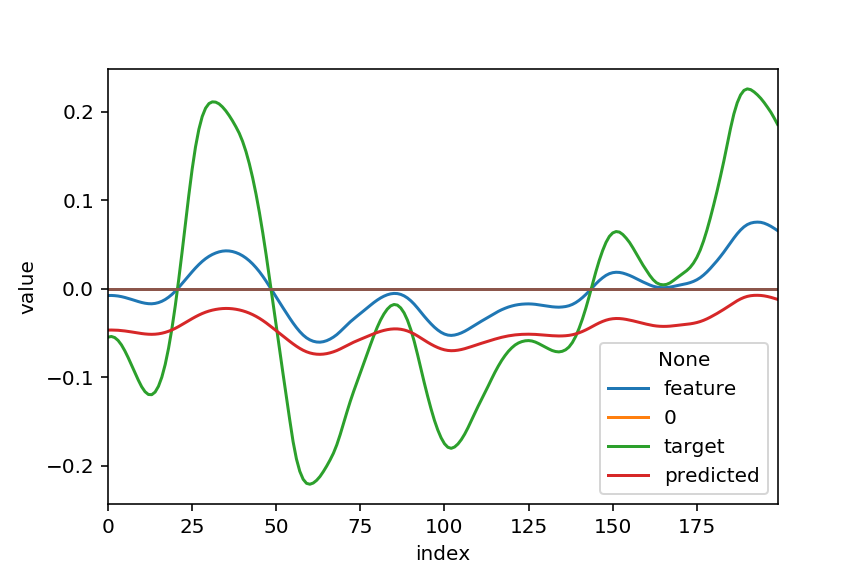

Epoch 1/100
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0324 - val_loss: 0.0412
Epoch 2/100
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0291 - val_loss: 0.0326
Epoch 3/100
 264/1000 [======>.......................] - ETA: 20s - loss: 0.0409

KeyboardInterrupt: 

In [499]:
%%time
%matplotlib notebook

# TRAIN

# N_SAMPLES = 20000
# N_SAMPLES = 8800
# N_SAMPLES = 100

es_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=4,
    verbose=0,
    mode='auto',
)

history = model.fit(
#     X_tr_s[:N_SAMPLES],
#     y_tr_s[:N_SAMPLES],
    X_tr_s[:1000],
    y_tr_s[:1000],
    batch_size=BATCH_SIZE,
    shuffle=False,
#     epochs=400,
    epochs=100,
    verbose=1,
    validation_data=(X_te_s[:400], y_te_s[:400]),
    # validation_data=(X_te_s[:200], y_te_s[:200]),
    # callbacks=[es_cb, test_model_cb, tensorboard_cb],
    callbacks=[es_cb, test_model_cb],
)


In [500]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[array([[0.9610148 , 0.90371776, 1.1668121 , 1.0560107 , 1.0646862 ,
        1.0175797 , 0.9265292 , 0.9469326 , 0.85840476, 0.9265448 ]],
      dtype=float32), array([-0.00125339,  0.00311181, -0.00176163, -0.00419943, -0.0102162 ,
       -0.00425761,  0.00450747, -0.00129743,  0.00343726,  0.00130588],
      dtype=float32)]
[array([[-3.64859402e-01,  2.70034283e-01, -1.43224612e-01,
         2.73843203e-03, -3.26671243e-01,  1.08576171e-01,
        -2.94480205e-01, -2.84240961e-01,  7.71064013e-02,
         1.61920831e-01,  3.50670993e-01, -1.04607046e-01,
        -2.73516446e-01,  3.34250003e-01,  3.27896595e-01,
        -1.85980096e-01, -1.32494852e-01,  7.97929689e-02,
        -2.49759048e-01, -2.35661477e-01, -1.70152143e-01,
         4.79693562e-01, -5.69576360e-02,  2.63192534e-01,
         1.39697999e-01, -1.42082289e-01, -2.19126165e-01,
        -2.82648802e-01,  1.41136363e-01,  1.65651426e-01],
       [-3.07506442e-01,  5.34477681e-02,  1.37296626e-02,
         3.76471668e-

[array([[0.91220146],
       [0.9275776 ],
       [0.8597461 ],
       [0.93804836],
       [0.73935676],
       [0.74941427],
       [0.72450453],
       [0.795252  ],
       [0.8795842 ],
       [0.7091981 ]], dtype=float32), array([-0.0110932], dtype=float32)]


In [351]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (1, 64, 20)               40        
_________________________________________________________________
gru_26 (GRU)                 (1, 20)                   2460      
_________________________________________________________________
dense_23 (Dense)             (1, 1)                    21        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [374]:
score = model.evaluate(X_te_s[:400], y_te_s[:400], verbose=0, batch_size=BATCH_SIZE)
score

0.021763145157601683

In [265]:
0.005132799269631505

0.005132799269631505

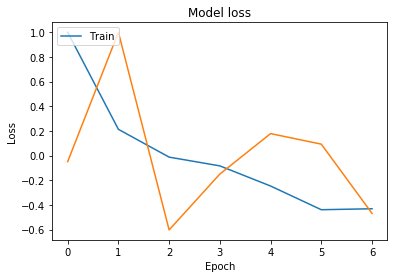

In [266]:
from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [267]:
len(X_te_f)

10000

In [269]:
predict(model, X_te_s[:100])

array([ 0.00720847,  0.00390608,  0.00069414, -0.00238913, -0.00538246,
       -0.0082476 , -0.01097245, -0.01364918, -0.01623574, -0.01858433,
       -0.0209128 , -0.02311743, -0.02515342, -0.0271521 , -0.0289777 ,
       -0.03068439, -0.03238854, -0.03380311, -0.03520663, -0.03654917,
       -0.03762048, -0.03861776, -0.03963517, -0.04040424, -0.04111475,
       -0.04170411, -0.04220744, -0.04252864, -0.04285228, -0.04293739,
       -0.04293268, -0.04301209, -0.04282712, -0.0426129 , -0.0423735 ,
       -0.04189257, -0.04140666, -0.04086066, -0.0401896 , -0.03941978,
       -0.03869359, -0.03782381, -0.03685462, -0.03586413, -0.03482395,
       -0.03364499, -0.03251233, -0.03126309, -0.03004637, -0.02876272,
       -0.02733327, -0.02604197, -0.02467418, -0.02319817, -0.02179869,
       -0.02037514, -0.01891786, -0.0175517 , -0.01616797, -0.01475757,
       -0.01333211, -0.01194194, -0.01061384, -0.00931575, -0.00807026,
       -0.00677356, -0.00557142, -0.00450684, -0.00338372, -0.00

In [270]:
print(X_tr_s[0][-1])

[-0.00759911]


0   -0.060514
1   -0.058674
2   -0.058097
3   -0.058697
4   -0.060560
dtype: float32


Text(0,0.5,'value')

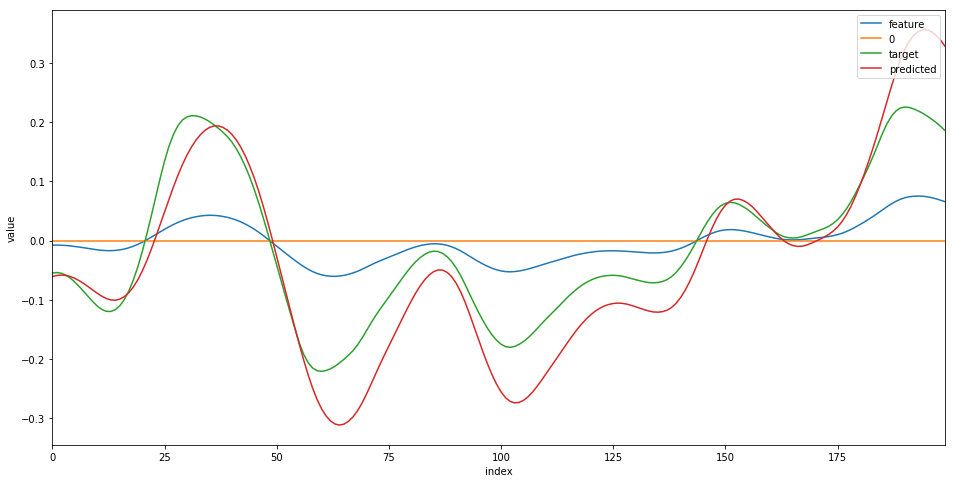

In [387]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 200

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

feat.plot.line(ax=ax, label='feature')

targ = (pd.Series((y_tr_s[:I])))

pred = pd.Series(predict(model, X_tr_s[:I]))
pred = (pred * 3.2) + 0.001
# pred = pred + 0.001

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

targ.plot.line(ax=ax, label='target')

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

## Time to evaluate performance

In [75]:
predictions = predict(model, X_tr_f[:10000])
len(predictions), predictions[:10]

ValueError: Error when checking input: expected gru_1_input to have 3 dimensions, but got array with shape (10000, 2)

In [ ]:
wavfile.write('output/clean_train_pred_out.wav', source_clean_fs, predictions)

In [ ]:
len(predictions)